In [385]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numbers
import sys
import random
import utils as utl
import statsmodels.api as sm
import pickle
from sklearn.linear_model import LogisticRegressionCV,LinearRegression,LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split,StratifiedKFold
import math
import xgboost as xgb
from imblearn.over_sampling import BorderlineSMOTE
from collections import Counter
import lightgbm as lgb

In [2]:
sns.set(style = 'white', context = 'notebook', palette = 'deep')
sns.set_style('white')
pd.set_option('display.max_columns',400)
pd.set_option('display.max_rows',1000)

In [62]:
alltrainData = pd.read_csv('./data/alltraindata3.csv',encoding = 'gbk')
alltestData = pd.read_csv('./data/alltestdata3.csv')
allFeatures = list(alltrainData.columns)
allFeatures.remove('target')
if 'Idx' in allFeatures:
    allFeatures.remove('Idx')
allFeatures.remove('ListingInfo')

- **数据集中度检验**

筛选出数据集中度超过90%的特征，当“多数值”与“少数值”有显著差别，且“少数值”的坏样本率高于“多数值”，表明“少数值”的存在对应的风险很高，特征需要保留。我们用特征中“少数值”坏样本率和“多数值”坏样本率之比的对数值作为指标，超过2.303(即两者的坏样本率比值超过10)则表明该特征需要保留。

In [63]:
numerical_var = []
for col in allFeatures:
    if len(set(alltrainData[col])) == 1:
        print('delete {} from the dataset because it is a constant'.format(col))
        del alltrainData[col]
        allFeatures.remove(col)
    else:
        uniq_valid_vals = [i for i in alltrainData[col] if i == i]
        uniq_valid_vals = list(set(uniq_valid_vals))
        if len(uniq_valid_vals) >= 10 and isinstance(uniq_valid_vals[0], numbers.Real):
            numerical_var.append(col)

categorical_var = [i for i in allFeatures if i not in numerical_var]

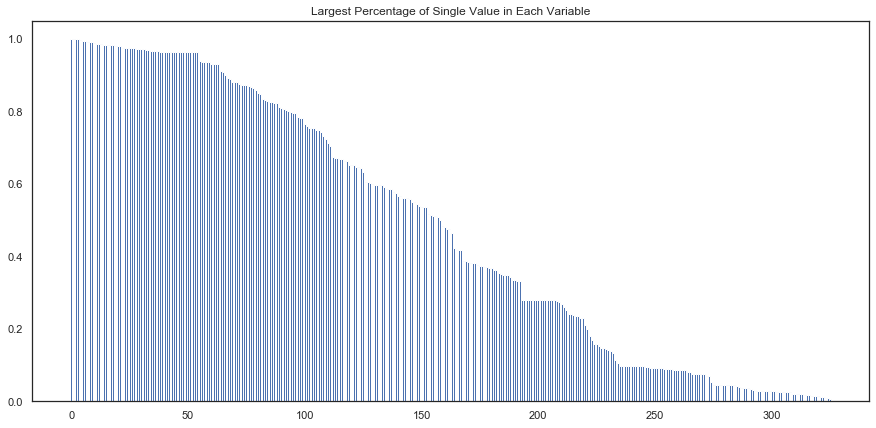

In [64]:
#检查是否有常数型变量，并且检查是类别型还是数值型变量
numerical_var = []
for col in allFeatures:
    if len(set(alltrainData[col])) == 1:
        print('delete {} from the dataset because it is a constant'.format(col))
        del alltrainData[col]
        allFeatures.remove(col)
    else:
        uniq_valid_vals = [i for i in alltrainData[col] if i == i]
        uniq_valid_vals = list(set(uniq_valid_vals))
        if len(uniq_valid_vals) >= 10 and isinstance(uniq_valid_vals[0], numbers.Real):
            numerical_var.append(col)

categorical_var = [i for i in allFeatures if i not in numerical_var]

#检查变量的最多值的占比情况,以及每个变量中占比最大的值
records_count = alltrainData.shape[0]
col_most_values,col_large_value = {},{}
for col in allFeatures:
    value_count = alltrainData[col].groupby(alltrainData[col]).count()
    col_most_values[col] = max(value_count)/records_count
    large_value = value_count[value_count== max(value_count)].index[0]
    col_large_value[col] = large_value
col_most_values_df = pd.DataFrame.from_dict(col_most_values, orient = 'index')
col_most_values_df.columns = ['max percent']
col_most_values_df = col_most_values_df.sort_values(by = 'max percent', ascending = False)
pcnt = list(col_most_values_df[:500]['max percent'])
vars = list(col_most_values_df[:500].index)
plt.figure(figsize=[15,7])
plt.bar(range(len(pcnt)), height = pcnt)
plt.title('Largest Percentage of Single Value in Each Variable');

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


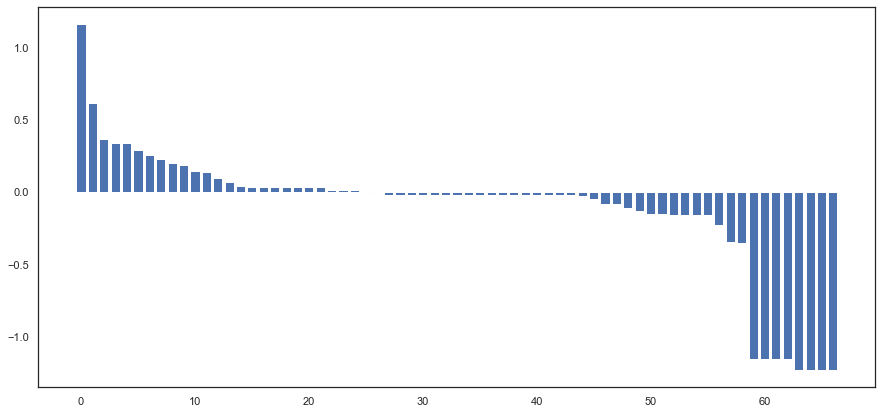

In [65]:
#计算多数值产比超过90%的字段中，少数值的坏样本率是否会显著高于多数值
large_percent_cols = list(col_most_values_df[col_most_values_df['max percent']>=0.9].index)
bad_rate_diff = {}
for col in large_percent_cols:
    large_value = col_large_value[col]
    temp = alltrainData[[col,'target']]
    temp[col] = temp.apply(lambda x: int(x[col]==large_value),axis=1)
    bad_rate = temp.groupby(col).mean()
    if bad_rate.iloc[0]['target'] == 0:
        bad_rate_diff[col] = 0
        continue
    bad_rate_diff[col] = np.log(bad_rate.iloc[0]['target']/bad_rate.iloc[1]['target'])
bad_rate_diff_sorted = sorted(bad_rate_diff.items(),key=lambda x: x[1], reverse=True)
bad_rate_diff_sorted_values = [x[1] for x in bad_rate_diff_sorted]
plt.figure(figsize=[15,7])
plt.bar(x = range(len(bad_rate_diff_sorted_values)), height = bad_rate_diff_sorted_values);

于所有的少数值的坏样本率并没有显著高于多数值，意味着这些变量可以直接剔除

In [66]:
for col in large_percent_cols:
    if col in numerical_var:
        numerical_var.remove(col)
    else:
        categorical_var.remove(col)
    del alltrainData[col]
    del alltestData[col]

In [70]:
alltrainData.to_csv('./data/alltrainDatakk.csv',index=False,encoding = 'gbk')
alltestData.to_csv('./data/alltestDatakk.csv',index=False)

- **缺失值处理**

In [90]:
alltrainData = pd.read_csv('./data/alltraindatakk.csv',encoding = 'gbk')
alltestData = pd.read_csv('./data/alltestdatakk.csv')
alltrainData = pd.concat([alltrainData,alltestData],axis=0)

In [91]:
# 对类别型变量，如果缺失超过80%, 就删除，否则当成特殊的状态

def MissingCategorial(df,x):
    missing_vals = df[x].map(lambda x: int(x!=x))
    return sum(missing_vals)*1.0/df.shape[0]

missing_pcnt_threshould_1 = 0.8
for col in categorical_var:
    missingRate = MissingCategorial(alltrainData,col)
#     alltestData[col] = alltestData[col].map(lambda x: int(x!=x))
    print('{0} has missing rate as {1}'.format(col,missingRate))
    if missingRate > missing_pcnt_threshould_1:
        categorical_var.remove(col)
        del alltrainData[col]
#         del alltestData[col]
    if 0 < missingRate < missing_pcnt_threshould_1:
        # In this way we convert NaN to NAN, which is a string instead of np.nan
        alltrainData[col] = alltrainData[col].map(lambda x: str(x).upper())
#         alltestData[col] = alltestData[col].map(lambda x: str(x).upper())

SocialNetwork_12 has missing rate as 0.0
SocialNetwork_13 has missing rate as 0.0
SocialNetwork_17 has missing rate as 0.0
UserInfo_1 has missing rate as 0.00018750234377929725
UserInfo_10 has missing rate as 0.0
UserInfo_11 has missing rate as 0.6332079150989387
UserInfo_12 has missing rate as 0.6332079150989387
UserInfo_13 has missing rate as 0.6332079150989387
UserInfo_14 has missing rate as 0.0
UserInfo_15 has missing rate as 0.0
UserInfo_16 has missing rate as 0.0
UserInfo_17 has missing rate as 0.0
UserInfo_19 has missing rate as 0.0
UserInfo_2 has missing rate as 0.009162614532681659
UserInfo_20 has missing rate as 0.2371404642558032
UserInfo_3 has missing rate as 0.0002000025000312504
UserInfo_4 has missing rate as 0.008112601407517593
UserInfo_5 has missing rate as 0.0
UserInfo_6 has missing rate as 0.0
UserInfo_7 has missing rate as 0.0
UserInfo_8 has missing rate as 0.14158926986587334
UserInfo_9 has missing rate as 0.0
WeblogInfo_19 has missing rate as 0.09830122876535957
W

In [92]:
# 检查数值型变量

def MissingContinuous(df,x):
    missing_vals = df[x].map(lambda x: int(np.isnan(x)))
    return sum(missing_vals) * 1.0 / df.shape[0]

missing_pcnt_threshould_2 = 0.8
deleted_var = []
for col in numerical_var:
    missingRate = MissingContinuous(alltrainData, col)
#     alltestData[col] = alltestData[col].map(lambda x: int(np.isnan(x)))
    print('{0} has missing rate as {1}'.format(col, missingRate))
    if missingRate > missing_pcnt_threshould_2:
        deleted_var.append(col)
        print('we delete variable {} because of its high missing rate'.format(col))
    else:
        if missingRate > 0:
#             not_missing = alltrainData.loc[alltrainData[col] == alltrainData[col]][col]
#             missing_position = alltrainData.loc[alltrainData[col] != alltrainData[col]][col].index
#             not_missing_sample = random.sample(list(not_missing), len(missing_position))
#             alltrainData.loc[missing_position,col] = not_missing_sample
            alltrainData[col] = alltrainData[col].fillna(-1)
            missingRate2 = MissingContinuous(alltrainData, col)
            print('missing rate after making up is:{}'.format(str(missingRate2)))

if deleted_var != []:
    for col in deleted_var:
        numerical_var.remove(col)
        del alltrainData[col]
#         del alltestData[col]

SocialNetwork_10 has missing rate as 0.0
SocialNetwork_8 has missing rate as 0.0
SocialNetwork_9 has missing rate as 0.0
ThirdParty_Info_Period1_1 has missing rate as 0.0
ThirdParty_Info_Period1_10 has missing rate as 0.0
ThirdParty_Info_Period1_11 has missing rate as 0.0
ThirdParty_Info_Period1_12 has missing rate as 0.0
ThirdParty_Info_Period1_13 has missing rate as 0.0
ThirdParty_Info_Period1_14 has missing rate as 0.0
ThirdParty_Info_Period1_15 has missing rate as 0.0
ThirdParty_Info_Period1_16 has missing rate as 0.0
ThirdParty_Info_Period1_17 has missing rate as 0.0
ThirdParty_Info_Period1_2 has missing rate as 0.0
ThirdParty_Info_Period1_3 has missing rate as 0.0
ThirdParty_Info_Period1_4 has missing rate as 0.0
ThirdParty_Info_Period1_5 has missing rate as 0.0
ThirdParty_Info_Period1_6 has missing rate as 0.0
ThirdParty_Info_Period1_7 has missing rate as 0.0
ThirdParty_Info_Period1_8 has missing rate as 0.0
ThirdParty_Info_Period1_9 has missing rate as 0.0
ThirdParty_Info_Perio

UserupdateInfo_180_unique has missing rate as 0.0001000012500156252
missing rate after making up is:0.0
UserupdateInfo_180_avg_count has missing rate as 0.0001000012500156252
missing rate after making up is:0.0
LogInfo1_7_count has missing rate as 0.032912911411392645
missing rate after making up is:0.0
LogInfo1_7_unique has missing rate as 0.032912911411392645
missing rate after making up is:0.0
LogInfo1_7_avg_count has missing rate as 0.032912911411392645
missing rate after making up is:0.0
LogInfo2_7_count has missing rate as 0.032912911411392645
missing rate after making up is:0.0
LogInfo2_7_unique has missing rate as 0.032912911411392645
missing rate after making up is:0.0
LogInfo2_7_avg_count has missing rate as 0.032912911411392645
missing rate after making up is:0.0
LogInfo1_30_count has missing rate as 0.032912911411392645
missing rate after making up is:0.0
LogInfo1_30_unique has missing rate as 0.032912911411392645
missing rate after making up is:0.0
LogInfo1_30_avg_count ha

- **卡方分箱**

In [94]:
for col in categorical_var:
    #for Chinese character, upper() is not valid
    if col not in ['UserInfo_2','UserInfo_4','UserInfo_7','UserInfo_8','UserInfo_9','UserInfo_19','UserInfo_20']:
        alltrainData[col] = alltrainData[col].map(lambda x: str(x).upper())
#         alltestData[col] = alltestData[col].map(lambda x: str(x).upper())

In [95]:
alltrainData.to_csv('./data/alltrainDatakkk.csv',index=False,encoding = 'gbk')

对于类别型变量，按照以下方式处理
- 如果变量的取值个数超过5，计算bad rate进行编码
- 除此之外，其他任何类别型变量如果有某个取值中，对应的样本全部是坏样本或者是好样本，进行合并。

In [96]:
deleted_features = []   #将处理过的变量删除，防止对后面建模的干扰
encoded_features = {}   #将bad rate编码方式保存下来，在以后的测试和生产环境中需要使用
merged_features = {}    #将类别型变量合并方案保留下来
var_IV = {}   #保留IV值和WOE值
var_WOE = {}
for col in categorical_var:
    print('we are processing {}'.format(col))
    if len(set(alltrainData[col]))>5:
        print('{} is encoded with bad rate'.format(col))
        col0 = str(col)+'_encoding'

        #(1), 计算坏样本率并进行编码
        encoding_result = utl.BadRateEncoding(alltrainData, col, 'target')
        alltrainData[col0], br_encoding = encoding_result['encoding'],encoding_result['bad_rate']

        #(2), 将（1）中的编码后的变量也加入数值型变量列表中，为后面的卡方分箱做准备
        numerical_var.append(col0)

        #(3), 保存编码结果
        encoded_features[col] = [col0, br_encoding]

        #(4), 删除原始值
        deleted_features.append(col)
    else:
        bad_bin = alltrainData.groupby([col])['target'].sum()
        #对于类别数少于5个，但是出现0坏样本的特征需要做处理
        if min(bad_bin) == 0:
            print('{} has 0 bad sample!'.format(col))
            col1 = str(col) + '_mergeByBadRate'
            #(1), 找出最优合并方式，使得每一箱同时包含好坏样本
            mergeBin = utl.MergeBad0(alltrainData, col, 'target')
            #(2), 依照（1）的结果对值进行合并
            alltrainData[col1] = alltrainData[col].map(mergeBin)
            maxPcnt = utl.MaximumBinPcnt(alltrainData, col1)
            #如果合并后导致有箱占比超过90%，就删除。
            if maxPcnt > 0.9:
                print('{} is deleted because of large percentage of single bin'.format(col))
                deleted_features.append(col)
                categorical_var.remove(col)
                del alltrainData[col]
                del alltrainData[col1]
                continue
            #(3) 如果合并后的新的变量满足要求，就保留下来
            merged_features[col] = [col1, mergeBin]
            WOE_IV = utl.CalcWOE(alltrainData, col1, 'target')
            var_WOE[col1] = WOE_IV['WOE']
            var_IV[col1] = WOE_IV['IV']
            deleted_features.append(col)
        else:
            WOE_IV = utl.CalcWOE(alltrainData, col, 'target')
            var_WOE[col] = WOE_IV['WOE']
            var_IV[col] = WOE_IV['IV']

we are processing SocialNetwork_12
we are processing SocialNetwork_13
SocialNetwork_13 has 0 bad sample!
we are processing SocialNetwork_17
SocialNetwork_17 has 0 bad sample!
we are processing UserInfo_1
UserInfo_1 is encoded with bad rate
we are processing UserInfo_10
we are processing UserInfo_11
we are processing UserInfo_12
we are processing UserInfo_13
we are processing UserInfo_14
UserInfo_14 is encoded with bad rate
we are processing UserInfo_15
UserInfo_15 is encoded with bad rate
we are processing UserInfo_16
UserInfo_16 is encoded with bad rate
we are processing UserInfo_17
we are processing UserInfo_19
UserInfo_19 is encoded with bad rate
we are processing UserInfo_2
UserInfo_2 is encoded with bad rate
we are processing UserInfo_20
UserInfo_20 is encoded with bad rate
we are processing UserInfo_3
UserInfo_3 is encoded with bad rate
we are processing UserInfo_4
UserInfo_4 is encoded with bad rate
we are processing UserInfo_5
we are processing UserInfo_6
we are processing User

In [97]:
# 删除处理过的变量       
alltrainData = alltrainData[alltrainData.columns.difference(deleted_features)]

alltrainData.to_csv('./data/alltrainData_nonumerical_woe.csv',index=False, encoding = 'gbk')

folderOfData = './data/'
with open(folderOfData+'categorical_var_WOE.pkl',"wb") as f:
    f.write(pickle.dumps(var_WOE))

with open(folderOfData+'categorical_var_IV.pkl',"wb") as f:
    f.write(pickle.dumps(var_IV))

with open(folderOfData+'categorical_encoded_features.pkl',"wb") as f:
    f.write(pickle.dumps(encoded_features))

with open(folderOfData+'categorical_merged_features.pkl',"wb") as f:
    f.write(pickle.dumps(merged_features))

In [98]:
alltrainData = pd.read_csv('./data/alltrainData_nonumerical_woe.csv',encoding = 'gbk')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (186,187,188,189,193,194,195,196,200,201,202,203,207,208,209,210,214,215,216,217,221,222,223,227,228,229,230) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


对于连续型变量：

- 利用卡方分箱法将变量分成5个箱
- 检查坏样本率的单带性，如果发现单调性不满足，就进行合并，直到满足单调性

In [99]:
var_cutoff = {}
for col in numerical_var:
    print("{} is in processing".format(col))
    col1 = str(col) + '_Bin'

    #(1),用卡方分箱法进行分箱，并且保存每一个分割的端点。例如端点=[10,20,30]表示将变量分为x<10,10<x<20,20<x<30和x>30.
    #特别地，缺失值-1不参与分箱
    if -1 in set(alltrainData[col]):
        special_attribute = [-1]
    else:
        special_attribute = []
    cutOffPoints = utl.ChiMerge(alltrainData, col, 'target',special_attribute=special_attribute)
    var_cutoff[col] = cutOffPoints
    alltrainData[col1] = alltrainData[col].map(lambda x: utl.AssignBin(x, cutOffPoints,special_attribute=special_attribute))

    #(2), check whether the bad rate is monotone
    BRM = utl.BadRateMonotone(alltrainData, col1, 'target',special_attribute=special_attribute)
    if not BRM:
        if special_attribute == []:
            bin_merged = utl.Monotone_Merge(alltrainData, 'target', col1)
            removed_index = []
            for bin in bin_merged:
                if len(bin)>1:
                    indices = [int(b.replace('Bin ','')) for b in bin]
                    removed_index = removed_index+indices[0:-1]
            removed_point = [cutOffPoints[k] for k in removed_index]
            for p in removed_point:
                cutOffPoints.remove(p)
            var_cutoff[col] = cutOffPoints
            alltrainData[col1] = alltrainData[col].map(lambda x: utl.AssignBin(x, cutOffPoints, special_attribute=special_attribute))
        else:
            cutOffPoints2 = [i for i in cutOffPoints if i not in special_attribute]
            temp = alltrainData.loc[~alltrainData[col].isin(special_attribute)]
            bin_merged = utl.Monotone_Merge(temp, 'target', col1)
            removed_index = []
            for bin in bin_merged:
                if len(bin) > 1:
                    indices = [int(b.replace('Bin ', '')) for b in bin]
                    removed_index = removed_index + indices[0:-1]
            removed_point = [cutOffPoints2[k] for k in removed_index]
            for p in removed_point:
                cutOffPoints2.remove(p)
            cutOffPoints2 = cutOffPoints2 + special_attribute
            var_cutoff[col] = cutOffPoints2
            alltrainData[col1] = alltrainData[col].map(lambda x: utl.AssignBin(x, cutOffPoints2, special_attribute=special_attribute))

    #(3), 分箱后再次检查是否有单一的值占比超过90%。如果有，删除该变量
    maxPcnt = utl.MaximumBinPcnt(alltrainData, col1)
    if maxPcnt > 0.9:
        deleted_features.append(col)
        numerical_var.remove(col)
        print('we delete {} because the maximum bin occupies more than 90%'.format(col))
        continue

    WOE_IV = utl.CalcWOE(alltrainData, col1, 'target')
    var_IV[col] = WOE_IV['IV']
    var_WOE[col] = WOE_IV['WOE']
#     del alltrainData[col]

SocialNetwork_10 is in processing


C:\Users\Susanna\Desktop\competition\2016年拍拍贷魔镜杯\utils.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['temp'] = df2[col].map(lambda x: AssignGroup(x, split_x))
C:\Users\Susanna\Desktop\competition\2016年拍拍贷魔镜杯\utils.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['temp_Bin'] = groupedvalues


SocialNetwork_8 is in processing
SocialNetwork_9 is in processing
ThirdParty_Info_Period1_1 is in processing
ThirdParty_Info_Period1_10 is in processing


C:\Users\Susanna\Desktop\competition\2016年拍拍贷魔镜杯\utils.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['temp'] = df2[col]


ThirdParty_Info_Period1_11 is in processing
ThirdParty_Info_Period1_12 is in processing
we delete ThirdParty_Info_Period1_12 because the maximum bin occupies more than 90%
ThirdParty_Info_Period1_14 is in processing
ThirdParty_Info_Period1_15 is in processing
ThirdParty_Info_Period1_16 is in processing
ThirdParty_Info_Period1_17 is in processing
ThirdParty_Info_Period1_2 is in processing
ThirdParty_Info_Period1_3 is in processing
ThirdParty_Info_Period1_4 is in processing
ThirdParty_Info_Period1_5 is in processing
ThirdParty_Info_Period1_6 is in processing
ThirdParty_Info_Period1_7 is in processing
ThirdParty_Info_Period1_8 is in processing
ThirdParty_Info_Period1_9 is in processing
ThirdParty_Info_Period2_1 is in processing
ThirdParty_Info_Period2_10 is in processing
ThirdParty_Info_Period2_11 is in processing
ThirdParty_Info_Period2_12 is in processing
ThirdParty_Info_Period2_13 is in processing
ThirdParty_Info_Period2_14 is in processing
ThirdParty_Info_Period2_15 is in processing
T

C:\Users\Susanna\Desktop\competition\2016年拍拍贷魔镜杯\utils.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['temp_Bin'] = groupedvalues


we delete WeblogInfo_33 because the maximum bin occupies more than 90%
WeblogInfo_4 is in processing
WeblogInfo_5 is in processing
WeblogInfo_6 is in processing
WeblogInfo_7 is in processing
WeblogInfo_8 is in processing
we delete WeblogInfo_8 because the maximum bin occupies more than 90%
UserupdateInfo_7_unique is in processing
UserupdateInfo_7_avg_count is in processing
UserupdateInfo_30_freq is in processing
UserupdateInfo_30_unique is in processing
UserupdateInfo_30_avg_count is in processing
UserupdateInfo_60_freq is in processing
UserupdateInfo_60_unique is in processing
UserupdateInfo_60_avg_count is in processing
UserupdateInfo_90_freq is in processing
UserupdateInfo_90_unique is in processing
UserupdateInfo_90_avg_count is in processing
UserupdateInfo_120_freq is in processing
UserupdateInfo_120_unique is in processing
UserupdateInfo_120_avg_count is in processing
UserupdateInfo_150_freq is in processing
UserupdateInfo_150_unique is in processing
UserupdateInfo_150_avg_count 

In [100]:
alltestData = alltestData[alltestData.columns.difference(deleted_features)]

In [101]:
alltrainData.to_csv('./data/alltrainData_final_woe.csv',index = False,encoding = 'gbk')
alltestData.to_csv('./data/alltestData_final_woe.csv',index = False)

folderOfData = './data/'
with open(folderOfData+'final_var_WOE.pkl',"wb") as f:
    f.write(pickle.dumps(var_WOE))

with open(folderOfData+'final_var_IV.pkl',"wb") as f:
    f.write(pickle.dumps(var_IV))

with open(folderOfData+'final_var_cutoff.pkl',"wb") as f:
    f.write(pickle.dumps(var_cutoff))

### 特征筛选

In [102]:
alltrainData = pd.read_csv('./data/alltrainData_final_woe.csv',encoding = 'gbk')

folderOfData = './data/'
with open(folderOfData+'final_var_WOE.pkl',"rb") as f:
    var_WOE = pickle.load(f)

with open(folderOfData+'final_var_IV.pkl',"rb") as f:
    var_IV = pickle.load(f)

with open(folderOfData+'final_var_cutoff.pkl',"rb") as f:
    var_cutoff = pickle.load(f)

with open(folderOfData+'categorical_merged_features.pkl',"rb") as f:
    merged_features = pickle.load(f)

- **WOE编码**

In [106]:
#将一些看起来像数值变量实际上是类别变量的字段转换成字符
num2str = ['SocialNetwork_12','UserInfo_6','UserInfo_5','UserInfo_10','UserInfo_17']
for col in num2str:
    alltrainData[col] = alltrainData[col].map(lambda x: str(x))

for col in var_WOE.keys():
    print(col)
    col2 = str(col)+"_WOE"
    if col in var_cutoff.keys():
        cutOffPoints = var_cutoff[col]
        special_attribute = []
        if - 1 in cutOffPoints:
            special_attribute = [-1]
        binValue = alltrainData[col].map(lambda x: utl.AssignBin(x, cutOffPoints,special_attribute=special_attribute))
        alltrainData[col2] = binValue.map(lambda x: var_WOE[col][x])
    else:
        alltrainData[col2] = alltrainData[col].map(lambda x: var_WOE[col][str(x)])

SocialNetwork_12
SocialNetwork_13_mergeByBadRate
SocialNetwork_17_mergeByBadRate
UserInfo_10
UserInfo_11
UserInfo_12
UserInfo_13
UserInfo_17
UserInfo_5
UserInfo_6
UserInfo_9
WeblogInfo_21
UserupdateInfo_7_hasbuycar
UserupdateInfo_7_marriagestatusid
UserupdateInfo_7_phone
UserupdateInfo_30_idnumber
UserupdateInfo_30_hasbuycar
UserupdateInfo_30_marriagestatusid
UserupdateInfo_30_phone
UserupdateInfo_60_idnumber
UserupdateInfo_60_hasbuycar
UserupdateInfo_60_marriagestatusid
UserupdateInfo_60_phone
UserupdateInfo_90_idnumber
UserupdateInfo_90_hasbuycar
UserupdateInfo_90_marriagestatusid
UserupdateInfo_90_phone
UserupdateInfo_120_idnumber
UserupdateInfo_120_hasbuycar
UserupdateInfo_120_marriagestatusid
UserupdateInfo_120_phone
UserupdateInfo_150_idnumber
UserupdateInfo_150_hasbuycar
UserupdateInfo_150_marriagestatusid
UserupdateInfo_150_phone
UserupdateInfo_180_idnumber
UserupdateInfo_180_hasbuycar
UserupdateInfo_180_marriagestatusid
UserupdateInfo_180_phone
city_allmatch
city_diff24
city_d

- **单变量特征选择**：选择IV高于阈值的变量

<BarContainer object of 247 artists>

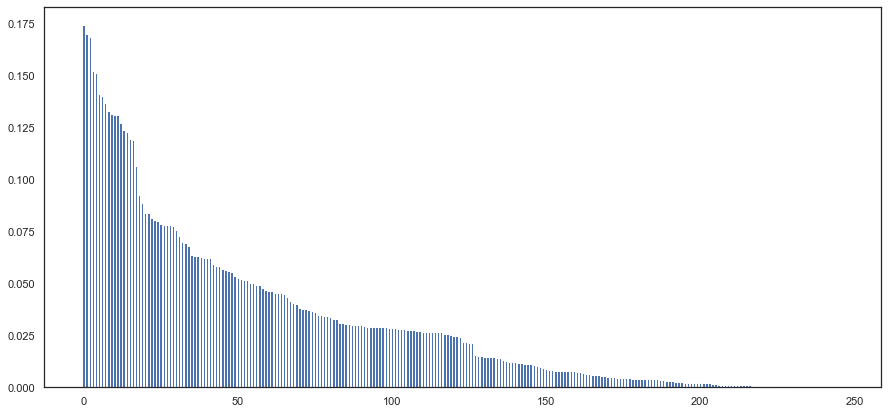

In [107]:
all_IV = list(var_IV.values())
all_IV = sorted(all_IV, reverse=True)
plt.figure(figsize=[15,7])
plt.bar(x=range(len(all_IV)), height = all_IV)

In [145]:
# 变量的IV普遍较低，需要放宽IV选择的条件。以0.01为阈值进行粗筛
iv_threshould = 0.01
varByIV = [k for k, v in var_IV.items() if v > iv_threshould]

- **多变量分析**

检查WOE编码后的变量的两两线性相关性

In [153]:
var_IV_selected = {k:var_IV[k] for k in varByIV}
var_IV_sorted = sorted(var_IV_selected.items(), key=lambda d:d[1], reverse = True)
var_IV_sorted = [i[0] for i in var_IV_sorted]

removed_var  = []
roh_thresould = 0.6
for i in range(len(var_IV_sorted)-1):
    if var_IV_sorted[i] not in removed_var:
        x1 = var_IV_sorted[i]+"_WOE"
        for j in range(i+1,len(var_IV_sorted)):
            if var_IV_sorted[j] not in removed_var:
                x2 = var_IV_sorted[j] + "_WOE"
                roh = np.corrcoef([alltrainData[x1], alltrainData[x2]])[0, 1]
                if abs(roh) >= roh_thresould:
                    print('the correlation coeffient between {0} and {1} is {2}'.format(x1, x2, str(roh)))
                    if var_IV[var_IV_sorted[i]] > var_IV[var_IV_sorted[j]]:
                        removed_var.append(var_IV_sorted[j])
                    else:
                        removed_var.append(var_IV_sorted[i])

var_IV_sortet_2 = [i for i in var_IV_sorted if i not in removed_var]

the correlation coeffient between ThirdParty_Info_Period2_6_WOE and ThirdParty_Info_Period3_6_WOE is 0.6995610985377892
the correlation coeffient between ThirdParty_Info_Period2_6_WOE and ThirdParty_Info_Period1_6_WOE is 0.636998849262867
the correlation coeffient between ThirdParty_Info_Period2_6_WOE and ThirdParty_Info_Period2_15_WOE is 0.7827978132316815
the correlation coeffient between ThirdParty_Info_Period4_6_WOE and ThirdParty_Info_Period5_6_WOE is 0.673035899892233
the correlation coeffient between ThirdParty_Info_Period4_6_WOE and ThirdParty_Info_Period4_15_WOE is 0.8169818611043633
the correlation coeffient between ThirdParty_Info_Period6_6_WOE and ThirdParty_Info_Period6_15_WOE is 0.8641341405753521
the correlation coeffient between ThirdParty_Info_Period6_6_WOE and ThirdParty_Info_Period6_8_WOE is 0.7480225843115279
the correlation coeffient between ThirdParty_Info_Period6_6_WOE and ThirdParty_Info_Period6_3_WOE is 0.704934635276085
the correlation coeffient between ThirdP

the correlation coeffient between LogInfo1_90_avg_count_WOE and LogInfo1_60_count_WOE is 0.8155373058149319
the correlation coeffient between LogInfo1_90_avg_count_WOE and LogInfo2_60_count_WOE is 0.8155373058149319
the correlation coeffient between LogInfo1_90_avg_count_WOE and LogInfo1_90_count_WOE is 0.8268182198961719
the correlation coeffient between LogInfo1_90_avg_count_WOE and LogInfo2_90_count_WOE is 0.8268182198961719
the correlation coeffient between LogInfo1_90_avg_count_WOE and LogInfo1_7_avg_count_WOE is 0.7733774260441396
the correlation coeffient between LogInfo1_90_avg_count_WOE and LogInfo2_60_avg_count_WOE is 0.8469976308697191
the correlation coeffient between LogInfo1_90_avg_count_WOE and LogInfo1_30_count_WOE is 0.7874745299160918
the correlation coeffient between LogInfo1_90_avg_count_WOE and LogInfo2_30_count_WOE is 0.7874745299160918
the correlation coeffient between LogInfo1_90_avg_count_WOE and LogInfo1_120_count_WOE is 0.8293253075033392
the correlation coef

检查是否有变量与其他所有变量的VIF > 10

In [154]:
for i in range(len(var_IV_sortet_2)):
    x0 = alltrainData[var_IV_sortet_2[i]+'_WOE']
    x0 = np.array(x0)
    X_Col = [k+'_WOE' for k in var_IV_sortet_2 if k != var_IV_sortet_2[i]]
    X = alltrainData[X_Col]
    X = np.matrix(X)
    regr = LinearRegression()
    clr= regr.fit(X, x0)
    x_pred = clr.predict(X)
    R2 = 1 - ((x_pred - x0) ** 2).sum() / ((x0 - x0.mean()) ** 2).sum()
    vif = 1/(1-R2)
    if vif > 10:
        print("Warning: the vif for {0} is {1}".format(var_IV_sortet_2[i], vif))

### 逻辑回归

In [193]:
multi_analysis = [i+'_WOE' for i in var_IV_sortet_2]
X,val_x, y, val_y = train_test_split(alltrainData[multi_analysis],alltrainData['target'],random_state=0,test_size=0.2)
X['intercept'] = [1]*X.shape[0]
LR = sm.Logit(y, X).fit()
summary = LR.summary2()
pvals = LR.pvalues.to_dict()
params = LR.params.to_dict()

Optimization terminated successfully.
         Current function value: 0.234880
         Iterations 8


对所有p值超过0.1的特征单独做一元逻辑回归模型，p值全部低于0.1，说明不显著的p值是由于线性相关性引起的

In [195]:
#发现有变量不显著，因此需要单独检验显著性
varLargeP = {k: v for k,v in pvals.items() if v >= 0.1}
varLargeP = sorted(varLargeP.items(), key=lambda d:d[1], reverse = True)
varLargeP = [i[0] for i in varLargeP]
p_value_list = {}
for var in varLargeP:
    X_temp = X[var].copy().to_frame() # 将数组转换为DataFrame
    X_temp['intercept'] = [1] * X_temp.shape[0]
    LR = sm.Logit(y, X_temp).fit()
    p_value_list[var] = LR.pvalues[var]
for k,v in p_value_list.items():
    print("{0} has p-value of {1} in univariate regression".format(k,v))

Optimization terminated successfully.
         Current function value: 0.264200
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.263746
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.261145
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.264466
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.265096
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.263287
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.263714
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.262720
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.264549
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.265116
  

In [196]:
#发现有变量的系数为正，因此需要单独检验正确性
varPositive = [k for k,v in params.items() if v >= 0]
coef_list = {}
for var in varPositive:
    X_temp = X[var].copy().to_frame()
    X_temp['intercept'] = [1] * X_temp.shape[0]
    LR = sm.Logit(y, X_temp).fit()
    coef_list[var] = LR.params[var]
for k,v in coef_list.items():
    print("{0} has coefficient of {1} in univariate regression".format(k,v))

Optimization terminated successfully.
         Current function value: 0.262742
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.263213
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.263287
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.263519
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.263746
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.264200
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.264466
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.264900
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.265116
         Iterations 7
ThirdParty_Info_Period4_8_WOE has coefficient of -0.9907242262292368 in univariate

对上述所有正系数的变量单独做一元逻辑回归模型，系数全部为-1

In [197]:
selected_var = [multi_analysis[0]]
for var in multi_analysis[1:]:
    try_vars = selected_var+[var]
    X_temp = X[try_vars].copy()
    X_temp['intercept'] = [1] * X_temp.shape[0]
    LR = sm.Logit(y, X_temp).fit()
    #summary = LR.summary2()
    pvals, params = LR.pvalues, LR.params
    del params['intercept']
    if max(pvals)<0.1 and max(params)<0:
        selected_var.append(var)

Optimization terminated successfully.
         Current function value: 0.258108
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.257068
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.253040
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.252020
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.251867
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.251574
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.251445
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.248330
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.247722
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.246150
  

train_ks :  0.35731761587928634
val_ks :  0.3618012097629492


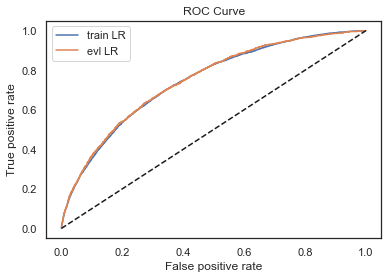

In [206]:
y_pred = LR.predict(X_temp)
fpr_lr_train,tpr_lr_train,_ = roc_curve(y,y_pred)
train_ks = abs(fpr_lr_train - tpr_lr_train).max()
print('train_ks : ',train_ks)

val_x['intercept'] = [1]*val_x.shape[0]
y_pred = LR.predict(val_x[X_temp.columns])
fpr_lr,tpr_lr,_ = roc_curve(val_y,y_pred)
val_ks = abs(fpr_lr - tpr_lr).max()
print('val_ks : ',val_ks)
from matplotlib import pyplot as plt
plt.plot(fpr_lr_train,tpr_lr_train,label = 'train LR')
plt.plot(fpr_lr,tpr_lr,label = 'evl LR')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc = 'best')
plt.show()

- **代价敏感采样**

train_ks :  0.3600265502553319
val_ks :  0.3607260462133031


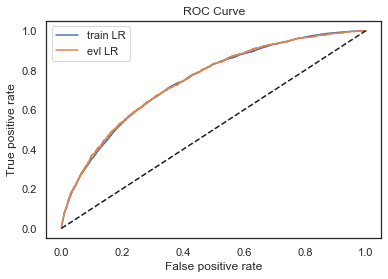

In [284]:
# del X_temp['intercept']
# del val_x['intercept']

lr_model = LogisticRegression(C=0.1,class_weight='balanced')
lr_model.fit(X_temp,y)
y_pred = lr_model.predict_proba(X_temp)[:,1]
fpr_lr_train,tpr_lr_train,_ = roc_curve(y,y_pred)
train_ks = abs(fpr_lr_train - tpr_lr_train).max()
print('train_ks : ',train_ks)

y_pred = lr_model.predict_proba(val_x[X_temp.columns])[:,1]
fpr_lr,tpr_lr,_ = roc_curve(val_y,y_pred)
val_ks = abs(fpr_lr - tpr_lr).max()
print('val_ks : ',val_ks)
from matplotlib import pyplot as plt
plt.plot(fpr_lr_train,tpr_lr_train,label = 'train LR')
plt.plot(fpr_lr,tpr_lr,label = 'evl LR')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc = 'best')
plt.show()

In [370]:
#生成报告
def report(model,evl_x,evl_y):
    row_num, col_num = 0, 0  
    bins = 20  
    Y_predict = [s[1] for s in model.predict_proba(evl_x)] 
    Y = evl_y  
    nrows = Y.shape[0]  
    lis = [(Y_predict[i], Y.tolist()[i]) for i in range(nrows)]  
    ks_lis = sorted(lis, key=lambda x: x[0], reverse=True)  
    bin_num = int(nrows/bins+1)  
    bad = sum([1 for (p, y) in ks_lis if y > 0.5])  
    good = sum([1 for (p, y) in ks_lis if y <= 0.5])  
    bad_cnt, good_cnt = 0, 0  
    KS = []  
    BAD = []  
    GOOD = []  
    BAD_CNT = []  
    GOOD_CNT = []  
    BAD_PCTG = []  
    BADRATE = []  
    dct_report = {}  
    for j in range(bins):  
        ds = ks_lis[j*bin_num: min((j+1)*bin_num, nrows)]  
        bad1 = sum([1 for (p, y) in ds if y > 0.5])  
        good1 = sum([1 for (p, y) in ds if y <= 0.5])  
        bad_cnt += bad1  
        good_cnt += good1  
        bad_pctg = round(bad_cnt/sum(evl_y),3)  
        badrate = round(bad1/(bad1+good1),3)  
        ks = round(math.fabs((bad_cnt / bad) - (good_cnt / good)),3)  
        KS.append(ks)  
        BAD.append(bad1)  
        GOOD.append(good1)  
        BAD_CNT.append(bad_cnt)  
        GOOD_CNT.append(good_cnt)  
        BAD_PCTG.append(bad_pctg)  
        BADRATE.append(badrate)  
        dct_report['KS'] = KS  
        dct_report['BAD'] = BAD  
        dct_report['GOOD'] = GOOD  
        dct_report['BAD_CNT'] = BAD_CNT  
        dct_report['GOOD_CNT'] = GOOD_CNT  
        dct_report['BAD_PCTG'] = BAD_PCTG  
        dct_report['BADRATE'] = BADRATE  
    val_repot = pd.DataFrame(dct_report)  
    return val_repot

report(lr_model,val_x[X_temp.columns],val_y)

,KS,BAD,GOOD,BAD_CNT,GOOD_CNT,BAD_PCTG,BADRATE
0,0.150,222,579,222,579,0.189,0.277
1,0.236,152,649,374,1228,0.319,0.190
2,0.290,118,683,492,1911,0.419,0.147
3,0.326,98,703,590,2614,0.503,0.122
4,0.335,68,733,658,3347,0.560,0.085
5,0.357,83,718,741,4065,0.631,0.104
6,0.347,48,753,789,4818,0.672,0.060
7,0.342,53,748,842,5566,0.717,0.066
8,0.336,52,749,894,6315,0.761,0.065
9,0.329,52,749,946,7064,0.806,0.065


In [287]:
#算分数onekey 
val = val_x[X_temp.columns]
cols = val.columns.tolist()
val['score'] = np.zeros((val.shape[0],1))
for i,col in enumerate(cols):
    val['score'] += val[col] * lr_model.coef_.tolist()[0][i]
val['score'] += lr_model.intercept_
val['score'] = 650-34* (val['score'] )/math.log(2)

fpr_lr,tpr_lr,_ = roc_curve(val_y,val['score'])
val_ks = abs(fpr_lr - tpr_lr).max()
print('val_ks : ',val_ks)

#对应评级区间
def level(score):
    level = 0
    if score <= 600:
        level = "D"
    elif score <= 640 and score > 600 : 
        level = "C"
    elif score <= 680 and score > 640:
        level = "B"
    elif  score > 680 :
        level = "A"
    return level
val['level'] = val.score.map(lambda x : level(x) )

val.level.groupby(val.level).count()/len(val)

val_ks :  0.36072604621330323


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

level
A    0.403687
B    0.325937
C    0.198063
D    0.072313
Name: level, dtype: float64

### 集成模型的评分映射

train_ks :  0.38279371339259594
evl_ks :  0.3768887752098103


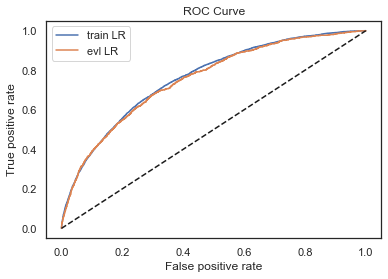

In [297]:
x = X_temp  
y = y  
evl_x =  val[X_temp.columns]  
evl_y = val_y  
  
#定义XGB函数  
def XGB_test(train_x,train_y,test_x,test_y):  
    from multiprocessing import cpu_count  
    clf = xgb.XGBClassifier(boosting_type='gbdt', num_leaves=31,
                            reg_alpha=0.0, reg_lambda=1,
                            max_depth=2, n_estimators=800,
                            max_features = 140, objective='binary:logistic',
                            subsample=0.7, colsample_bytree=0.7, subsample_freq=1,
                            learning_rate=0.05, min_child_weight=50,
                            n_jobs=cpu_count()-1,
                            num_iterations = 800 #迭代次数  
    )  
    clf.fit(train_x, train_y,eval_set=[(train_x, train_y),(test_x,test_y)],eval_metric='auc',early_stopping_rounds=100)  
    return clf

#模型训练
XGBmodel = XGB_test(x,y,evl_x,evl_y) 
#训练集预测
y_pred = XGBmodel.predict_proba(x)[:,1]  
fpr_xgb_train,tpr_xgb_train,_ = roc_curve(y,y_pred)  
train_ks = abs(fpr_xgb_train - tpr_xgb_train).max()  
print('train_ks : ',train_ks)  
#跨时间验证集预测
y_pred = XGBmodel.predict_proba(evl_x)[:,1]  
fpr_xgb,tpr_xgb,_ = roc_curve(evl_y,y_pred)  
evl_ks = abs(fpr_xgb - tpr_xgb).max()  
print('evl_ks : ',evl_ks)  
#画出ROC曲线并计算KS值
from matplotlib import pyplot as plt  
plt.plot(fpr_xgb_train,tpr_xgb_train,label = 'train LR')  
plt.plot(fpr_xgb,tpr_xgb,label = 'evl LR')  
plt.plot([0,1],[0,1],'k--')  
plt.xlabel('False positive rate')  
plt.ylabel('True positive rate')  
plt.title('ROC Curve')  
plt.legend(loc = 'best')  
plt.show() 

In [369]:
report(XGBmodel,evl_x[X_temp.columns],evl_y)

,KS,BAD,GOOD,BAD_CNT,GOOD_CNT,BAD_PCTG,BADRATE
0,0.173,247,554,247,554,0.210,0.308
1,0.269,163,638,410,1192,0.349,0.203
2,0.307,100,701,510,1893,0.434,0.125
3,0.338,93,708,603,2601,0.514,0.116
4,0.353,75,726,678,3327,0.578,0.094
5,0.364,71,730,749,4057,0.638,0.089
6,0.373,68,733,817,4790,0.696,0.085
7,0.360,45,756,862,5546,0.734,0.056
8,0.354,52,749,914,6295,0.779,0.065
9,0.327,30,771,944,7066,0.804,0.037


In [358]:
evl = evl_x[X_temp.columns]
# 定义评分映射函数
def score(pred):   
    score = 600+50*(math.log2((1- pred)/ pred))  
    return score  
evl['xbeta'] = XGBmodel.predict_proba(evl_x[X_temp.columns])[:,1]     
evl['score'] = evl.apply(lambda x : score(x.xbeta) ,axis=1)  
fpr_lr,tpr_lr,_ = roc_curve(evl_y,evl['score'])  
evl_ks = abs(fpr_lr - tpr_lr).max()  
print('val_ks : ',evl_ks) 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


val_ks :  0.37688877520981034


- **改写评价函数**
假设有个提额模型，用处是给分数最高的20%客户更高的额度，也就是使期望分数最高的20%的客群正样本捕获率最大化，同时模型对整体正负样本有一定区分能力。

In [360]:
# 自定义损失函数，需要提供损失函数的一阶导和二阶导  
def loglikelood(preds, dtrain):  
    labels = dtrain.get_label()  
    preds = 1.0 / (1.0 + np.exp(-preds))  
    grad = preds - labels  
    hess = preds * (1.0-preds)  
    return grad, hess  
  
# 自定义前20%正样本占比最大化评价函数  
def binary_error(preds, train_data):  
    labels = train_data.get_label()  
    dct = pd.DataFrame({'pred':preds,'percent':preds,'labels':labels})  
    #取百分位点对应的阈值  
    key = dct['percent'].quantile(0.2)  
    #按照阈值处理成二分类任务  
    dct['percent']= dct['percent'].map(lambda x :1 if x <= key else 0)    
    #计算评价函数，权重默认0.5，可以根据情况调整  
    result = np.mean(dct[dct.percent== 1]['labels'] == 1)*0.5 \
               + np.mean((dct.labels - dct.pred)**2)*0.5  
    return 'error',result  
  
dtrain = xgb.DMatrix(x, label=y)
dtest = xgb.DMatrix(evl_x[X_temp.columns], label=evl_y)   
watchlist  = [(dtest,'eval'), (dtrain,'train')]  
param = {'max_depth':3, 'eta':0.1, 'silent':1}  
num_round = 100  
# 自定义损失函数训练 
bst = xgb.train(param, dtrain, num_round, watchlist, loglikelood, binary_error) 

[0]	eval-rmse:0.322882	train-rmse:0.323759	eval-error:0.072259	train-error:0.072642
[1]	eval-rmse:0.256999	train-rmse:0.25896	eval-error:0.050311	train-error:0.050136
[2]	eval-rmse:0.315156	train-rmse:0.317253	eval-error:0.063698	train-error:0.063145
[3]	eval-rmse:0.428291	train-rmse:0.430135	eval-error:0.10636	train-error:0.10596
[4]	eval-rmse:0.552231	train-rmse:0.553981	eval-error:0.16582	train-error:0.165901
[5]	eval-rmse:0.674968	train-rmse:0.676492	eval-error:0.242271	train-error:0.241383
[6]	eval-rmse:0.793058	train-rmse:0.794331	eval-error:0.32785	train-error:0.327373
[7]	eval-rmse:0.905699	train-rmse:0.906965	eval-error:0.42379	train-error:0.423139
[8]	eval-rmse:1.01306	train-rmse:1.01431	eval-error:0.52688	train-error:0.526201
[9]	eval-rmse:1.11511	train-rmse:1.11614	eval-error:0.634225	train-error:0.634273
[10]	eval-rmse:1.21228	train-rmse:1.21319	eval-error:0.747467	train-error:0.74693
[11]	eval-rmse:1.30508	train-rmse:1.30595	eval-error:0.864283	train-error:0.863762
[12]	e

train_ks :  0.3908321719066502
evl_ks :  0.3602521791107339


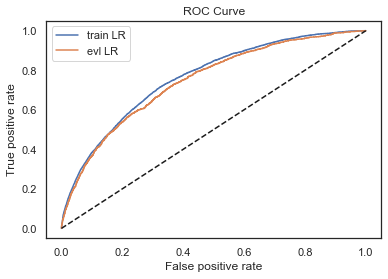

In [361]:
 #训练集预测
y_pred = bst.predict(dtrain) 
fpr_xgb_train,tpr_xgb_train,_ = roc_curve(y,y_pred)  
train_ks = abs(fpr_xgb_train - tpr_xgb_train).max()  
print('train_ks : ',train_ks)  
#跨时间验证集预测
y_pred = bst.predict(dtest)
fpr_xgb,tpr_xgb,_ = roc_curve(evl_y,y_pred)  
evl_ks = abs(fpr_xgb - tpr_xgb).max()  
print('evl_ks : ',evl_ks)  
#画出ROC曲线并计算KS值
from matplotlib import pyplot as plt  
plt.plot(fpr_xgb_train,tpr_xgb_train,label = 'train LR')  
plt.plot(fpr_xgb,tpr_xgb,label = 'evl LR')  
plt.plot([0,1],[0,1],'k--')  
plt.xlabel('False positive rate')  
plt.ylabel('True positive rate')  
plt.title('ROC Curve')  
plt.legend(loc = 'best')  
plt.show() 

In [384]:
#生成报告
row_num, col_num = 0, 0  
bins = 20  
dtest = xgb.DMatrix(evl_x[X_temp.columns],label=evl_y)
Y_predict = bst.predict(dtest).tolist()
Y = evl_y  
nrows = Y.shape[0]  
lis = [(Y_predict[i], Y.tolist()[i]) for i in range(nrows)]  
ks_lis = sorted(lis, key=lambda x: x[0], reverse=True)  
bin_num = int(nrows/bins+1)  
bad = sum([1 for (p, y) in ks_lis if y > 0.5])  
good = sum([1 for (p, y) in ks_lis if y <= 0.5])  
bad_cnt, good_cnt = 0, 0  
KS = []  
BAD = []  
GOOD = []  
BAD_CNT = []  
GOOD_CNT = []  
BAD_PCTG = []  
BADRATE = []  
dct_report = {}  
for j in range(bins):  
    ds = ks_lis[j*bin_num: min((j+1)*bin_num, nrows)]  
    bad1 = sum([1 for (p, y) in ds if y > 0.5])  
    good1 = sum([1 for (p, y) in ds if y <= 0.5])  
    bad_cnt += bad1  
    good_cnt += good1  
    bad_pctg = round(bad_cnt/sum(evl_y),3)  
    badrate = round(bad1/(bad1+good1),3)  
    ks = round(math.fabs((bad_cnt / bad) - (good_cnt / good)),3)  
    KS.append(ks)  
    BAD.append(bad1)  
    GOOD.append(good1)  
    BAD_CNT.append(bad_cnt)  
    GOOD_CNT.append(good_cnt)  
    BAD_PCTG.append(bad_pctg)  
    BADRATE.append(badrate)  
    dct_report['KS'] = KS  
    dct_report['BAD'] = BAD  
    dct_report['GOOD'] = GOOD  
    dct_report['BAD_CNT'] = BAD_CNT  
    dct_report['GOOD_CNT'] = GOOD_CNT  
    dct_report['BAD_PCTG'] = BAD_PCTG  
    dct_report['BADRATE'] = BADRATE  
val_repot = pd.DataFrame(dct_report)  
val_repot

,KS,BAD,GOOD,BAD_CNT,GOOD_CNT,BAD_PCTG,BADRATE
0,0.156,229,572,229,572,0.195,0.286
1,0.246,156,645,385,1217,0.328,0.195
2,0.295,112,689,497,1906,0.423,0.140
3,0.328,95,706,592,2612,0.504,0.119
4,0.345,77,724,669,3336,0.570,0.096
5,0.338,51,750,720,4086,0.613,0.064
6,0.352,74,727,794,4813,0.676,0.092
7,0.356,64,737,858,5550,0.731,0.080
8,0.348,50,751,908,6301,0.773,0.062
9,0.333,42,759,950,7060,0.809,0.052
